In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays
using Roots

In [2]:
module My

using Parameters 

@with_kw struct PhysicalParam{T} @deftype Float64 
    ħc = 197.
    mc² = 938.
    M = ħc^2/2mc²
    
    Z::Int64 = 8
    N::Int64 = 10
    A::Int64 = Z + N
    
    # parameters for initial density
    r₀ = 1.2
    R = r₀*A^(1/3)
    a = 0.67
    ρ₀ = 3/(4π*r₀^3)
    
    # skyrme parameters
    t₀ = -1800
    x₀ = 0.0
    t₃ = 12871
    x₃ = 0.0
    α = 1/3
    
    # radial grids
    Nr::Int64 = 200
    Δr = 0.1
    rs::T = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, R/Δr) + 1
    
    # energy
    Emin = -50.0
    Emax = +50.0
    ΔE = 0.1
    Es::T = range(Emin, Emax, step=ΔE)
    
    # buffer for integrating HF eq.
    ys_p::Vector{Float64} = similar(rs)
    ys_m::Vector{Float64} = similar(rs)
    
    Gs::Vector{Float64} = similar(rs)
    As::Vector{Float64} = similar(rs)
end

@with_kw struct QuantumNumbers @deftype Int64
    l = 0
    j = 1
    q = 1 # q=1 for neutron, q=2 for proton
end

@with_kw struct Densities
    ρq::Matrix{Float64}; @assert size(ρq, 2) === 2
    τq::Matrix{Float64}; @assert size(τq, 2) === 2
    ρtot::Vector{Float64}
    τtot::Vector{Float64}
end

@with_kw struct HFstates
    nstates_max::Int64
    spEs::Vector{Float64}; @assert length(spEs) === nstates_max
    qnums::Vector{QuantumNumbers} ; @assert length(qnums) === nstates_max
    wfs::Matrix{Float64}; @assert size(wfs, 2) === nstates_max
    occ::Vector{Float64}; @assert length(occ) === nstates_max
end

end # module My

Main.My

In [3]:
function make_HFstates(param; nstates_max=100)
    @unpack Nr = param 
    
    spEs  = zeros(Float64, nstates_max)
    spEs .= 1e10
    
    qnums = Vector{My.QuantumNumbers}(undef, nstates_max)
    wfs = zeros(Float64, Nr+1, nstates_max)
    occ = zeros(Float64, nstates_max)
    
    My.HFstates(nstates_max, spEs, qnums, wfs, occ)
end

make_HFstates (generic function with 1 method)

In [4]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}
  ħc: Float64 197.0
  mc²: Float64 938.0
  M: Float64 20.687100213219615
  Z: Int64 8
  N: Int64 10
  A: Int64 18
  r₀: Float64 1.2
  R: Float64 3.1448896730506757
  a: Float64 0.67
  ρ₀: Float64 0.13815533254504805
  t₀: Float64 -1800.0
  x₀: Float64 0.0
  t₃: Float64 12871.0
  x₃: Float64 0.0
  α: Float64 0.3333333333333333
  Nr: Int64 200
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 32
  Emin: Float64 -50.0
  Emax: Float64 50.0
  ΔE: Float64 0.1
  Es: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ys_p: Array{Float64}((201,)) [5.0e-324, 0.0, 0.0, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 5.0e-324, 2.5e-323  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0e-324, 2.1911024445e-314, 5.0e-324]
  ys_m: Array{Float64}((201,)) [2.17367286e-314, 2.1

In [5]:
function initial_density(param)
    @unpack A, N, Z, r₀, R, a, ρ₀, rs, Nr = param
    
    ρq = zeros(Float64, Nr+1, 2)
    τq = zeros(Float64, Nr+1, 2)
    ρtot = zeros(Float64, Nr+1)
    τtot = zeros(Float64, Nr+1)
    
    @. ρq[:,1] = (ρ₀*N/A)/(1 + exp((rs - R)/a))
    @. ρq[:,2] = (ρ₀*Z/A)/(1 + exp((rs - R)/a))
    @views @. ρtot = ρq[:,1] + ρq[:,2]
    
    return My.Densities(ρq, τq, ρtot, τtot)
end

function test_initial_density(param)
    @unpack rs = param 
    @time dens = initial_density(param)
    p = plot()
    plot!(rs, dens.ρq[:,1]; label="ρ_n")
    plot!(rs, dens.ρq[:,2]; label="ρ_p")
    plot!(rs, dens.ρtot; label="ρ_tot")
end

test_initial_density (generic function with 1 method)

  0.000006 seconds (4 allocations: 10.156 KiB)


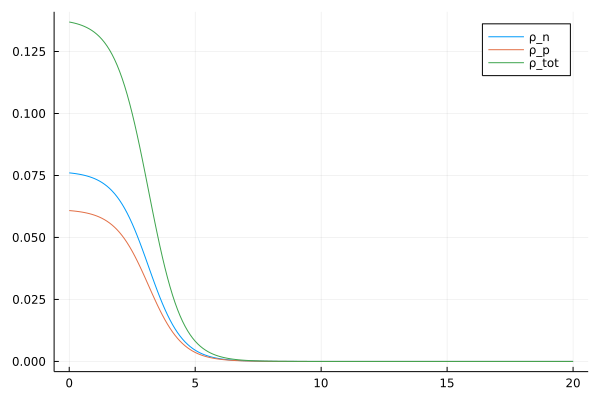

In [6]:
test_initial_density(param)

In [7]:
function calc_potential!(Vs, param, dens, qnum)
    @unpack M, t₀, x₀, t₃, x₃, α, rs = param 
    @unpack ρq, ρtot = dens
    @unpack l, j, q = qnum
    
    @views begin
        @. Vs  = t₀*((1+0.5x₀)*ρtot - (x₀+0.5)*ρq[:,q])
        
        @. Vs +=  1/12*t₃*(1+0.5x₃)*(α+2)*ρtot^(α+1)
        
        @. Vs += -1/12*t₃*(x₃+0.5)*α*(ρtot^(α-1))*
                    (ρq[:,1]*ρq[:,1]+ρq[:,2]*ρq[:,2])
        
        @. Vs += -1/12*t₃*(x₃+0.5)*2*(ρtot^α)*ρq[:,q]
        
        @. Vs += M*l*(l+1)/rs^2
    end
end

function test_calc_potential!(param; l=0)
    @unpack rs = param
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    p = plot(; ylim=(-60, 10))
    
    qnum = My.QuantumNumbers(l=l, q=1)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_n")
    
    qnum = My.QuantumNumbers(l=l, q=2)
    @time calc_potential!(Vs, param, dens, qnum)
    plot!(rs, Vs; label="V_p")
end

test_calc_potential! (generic function with 1 method)

  0.000009 seconds
  0.000006 seconds


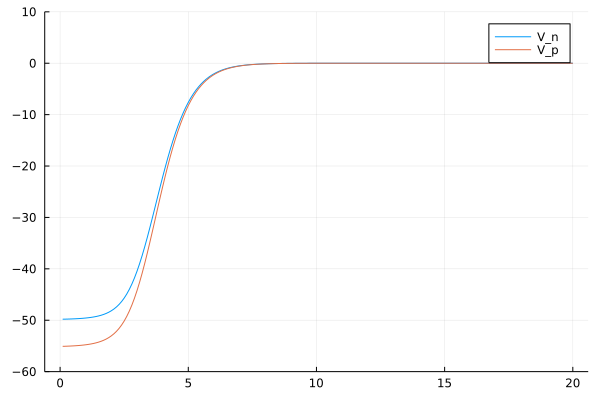

In [8]:
test_calc_potential!(param; l=0)

In [9]:
function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[ir]^2
    end
    norm *= Δr
    norm = sqrt(norm)
    @. ys /= norm
    return 
end

function integrate_HFeq!(param, Vs, E, qnum)
    @unpack M, Nr, Δr, rs, ir_matching, 
        ys_p, ys_m, Gs, As = param
    
    @unpack l, j, q = qnum
    
    @. As = 1 - (Δr*Δr/12)*(Vs-E)/M
    
    # outward integration
    fill!(ys_p, 0)
    ys_p[1] = 0.0
    ys_p[2] = Δr^(l+1)
    
    if l !== 1
        Gs[1] = 0.0
    else
        Gs[1] = - Δr*Δr/6
    end
    Gs[2] = As[2]*ys_p[2]
    
    for ir in 3:ir_matching+1
        Gs[ir] = 12ys_p[ir-1] - 10Gs[ir-1] - Gs[ir-2]
        ys_p[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_p, rs)
    
    # inward integration 
    fill!(ys_m, 0)
    ys_m[Nr+1] = 0.0
    ys_m[Nr  ] = Δr
    
    Gs[Nr+1] = 0.0
    Gs[Nr  ] = As[Nr]*ys_m[Nr]
    
    for ir in Nr-1: -1: ir_matching-1
        Gs[ir] = 12ys_m[ir+1] - 10Gs[ir+1] - Gs[ir+2]
        ys_m[ir] = As[ir]\Gs[ir]
    end
    
    normalize!(ys_m, rs)
    
    return
end

function test_integrate_HFeq!(param; E=-40.0, l=0, q=1)
    @unpack rs, Nr, Δr, ys_p, ys_m = param 
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    calc_potential!(Vs, param, dens, qnum)
    
    @time integrate_HFeq!(param, Vs, E, qnum)
    
    p = plot()
    plot!(rs, ys_p; label="ys_p")
    plot!(rs, ys_m; label="ys_m")
end

test_integrate_HFeq! (generic function with 1 method)

  0.000003 seconds


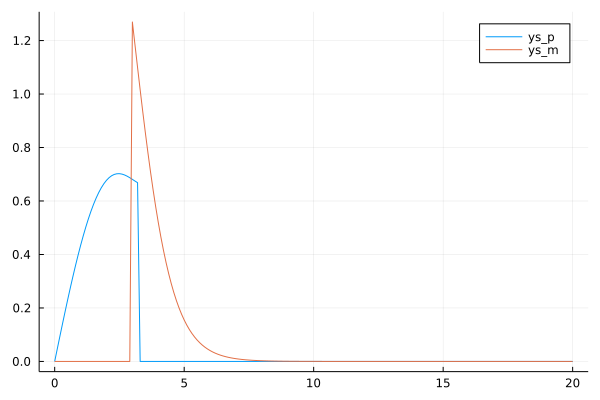

In [10]:
test_integrate_HFeq!(param; E=-40)

In [11]:
function calc_matching_condition(param)
    @unpack Δr, ir_matching, ys_p, ys_m = param
    
    ir = ir_matching 
    
    a = ys_p[ir]
    b = ys_m[ir]
    c = (ys_p[ir+1] - ys_p[ir-1])/2Δr
    d = (ys_m[ir+1] - ys_m[ir-1])/2Δr
    
    return a*d - b*c
end

calc_matching_condition (generic function with 1 method)

In [26]:
function test_calc_matching_condition(param; l=0, q=1)
    @unpack Nr, rs, Es, Δr, ys_p, ys_m = param 
    
    fs = similar(Es)
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    calc_potential!(Vs, param, dens, qnum)
    
    for iE in 1:length(Es)
        integrate_HFeq!(param, Vs, Es[iE], qnum)
        fs[iE] = calc_matching_condition(param)
    end
    
    fs
end

test_calc_matching_condition (generic function with 1 method)

  0.004649 seconds (6 allocations: 19.922 KiB)


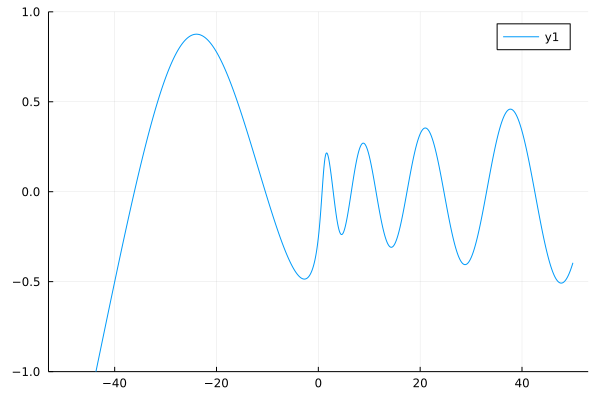

In [28]:
@time fs = test_calc_matching_condition(param; l=0)
plot(param.Es, fs; ylim=(-1,1))

In [19]:
function construct_eigenfunction!(ys, param, Vs, E, qnum)
    @unpack Nr, Δr, rs, ir_matching, ys_p, ys_m = param 
    
    integrate_HFeq!(param, Vs, E, qnum)
    
    ratio = ys_p[ir_matching]/ys_m[ir_matching]
    @. ys_m *= ratio 
    
    for ir in 1:ir_matching
        ys[ir] = ys_p[ir]
    end
    for ir in ir_matching+1:Nr+1
        ys[ir] = ys_m[ir]
    end
    
    normalize!(ys, rs)
    
    return
end

function shooting!(states, param, Vs, qnum)
    @unpack rs, Es = param 
    @unpack spEs, qnums, wfs = states
    
    function f(E)
        integrate_HFeq!(param, Vs, E, qnum)
        calc_matching_condition(param)
    end
    
    istate = 0
    for i in 1:length(Es)-1
        f₁ = f(Es[i])
        f₂ = f(Es[i+1])
        
        @views if f₁*f₂ < 0
            E = find_zero(f, (Es[i], Es[i+1]), Bisection())
            istate += 1
            spEs[istate] = E
            qnums[istate] = qnum
            construct_eigenfunction!(wfs[:, istate], param, Vs, E, qnum)
        end
    end
end

shooting! (generic function with 2 methods)

In [22]:
function test_shooting!(param; l=0, q=1)
    @unpack Nr, rs, Δr, Es, ys_p, ys_m = param 
    
    fs = similar(Es)
    
    qnum = My.QuantumNumbers(l=l, q=q)
    
    dens = initial_density(param)
    
    Vs = similar(rs)
    calc_potential!(Vs, param, dens, qnum)
    
    states = make_HFstates(param)
    
    @time shooting!(states, param, Vs, qnum)
    
    states.spEs[states.spEs .< 1e10]
end

test_shooting! (generic function with 1 method)

In [24]:
test_shooting!(param; l=0)

  0.009957 seconds (140 allocations: 27.031 KiB)


10-element Vector{Float64}:
 -36.12918358830279
 -10.409717339661928
   0.7398279578605651
   2.9239608046360663
   6.47920549845195
  11.331343077746753
  17.41254259504472
  24.664220233706942
  33.04036160200422
  42.508149628107965

In [ ]:
function calc_states!(states, param, Vs)
    @unpack rs = param 
    @unpack spEs, qnums[i], wfs = states
    
    function f(E)
        integrate_HFeq!(param, Vs, E, qnum)
        calc_matching_condition(param)
    end
    
    istate = 0
    for i in 1:length(Es)-1
        f₁ = f(Es[i])
        f₂ = f(Es[i+1])
        
        @views if f₁*f₂ < 0
            E = find_zero(f, (Es[i], Es[i+1]), Bisection())
            istate += 1
            spEs[istate] = E
            qnums[istate] = qnum
            construct_eigenfunction!(wfs[:, istate], param, Vs, E, qnum)
            normalize!(wfs[:,istate], rs)
        end
    end
end